----------------

```{admonition} Learning Objectives
* Do distance/proximity based analysis for points, lines, polygons
* Create buffers
* Get nearest neighbors
```
```{admonition} Review
* [Geospatial Vector Data](c_vectors.md)
* [Attributes & Indexing for Vector Data](e_attributes.md)
* [Creating Geospatial Vector Data](e_new_vectors.md)
```
----------------

# Proximity Analysis - Buffers, Nearest Neighbor 
In this chapter we are going to dig into some of the most common geospatial operations. After this section you will be able to answer simple questions like "where is the nearest wendy's?", "Are there any homes within 50 yards of a highway?".
 

## Buffer Analysis
First, we will import the necessary modules and create two lines (click the + below to show code cell).

In [1]:
# Import modules
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon
from io import StringIO 

data = """
ID,X,Y
1,  -87.789,  41.976
1,  -87.482,  41.677
2,  -87.599,  41.908
2,  -87.598,  41.708
2,  -87.643,  41.675
"""
# use StringIO to read in text chunk
df = pd.read_table(StringIO(data), sep=',')

#zip the coordinates into a point object and convert to a GeoData Frame
points = [Point(xy) for xy in zip(df.X, df.Y)]
points = gpd.GeoDataFrame(df, geometry=points, crs = 'EPSG:4326')
# create line for each ID 
lines = points.groupby(['ID'])['geometry'].apply(lambda x:  LineString(x.tolist()))
lines = gpd.GeoDataFrame(lines, geometry='geometry', crs="EPSG:4326") 
lines.reset_index(inplace=True)


Let's take a look at the data.

<AxesSubplot:>

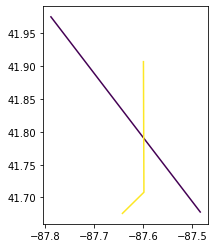

In [2]:
# plot county outline and add wells to axis (ax)
lines.plot(column='ID')

```{important} NEVER do distance analysis with unprojeted data (e.g. lat lon). Distances are best not measured in degrees! Instead use .to_crs() to convert it to a projected coordinate system with a linear unit in feet or meters etc.
```

Although it is not clearly stated the `distance` parameter is measured in the linear unit of the projection. So before we get started we need to make sure to use `to_crs()` to convert to a projected coordinate system.

In [3]:
# plot county outline and add wells to axis (ax)
lines = lines.to_crs(3857)
# check the linear unit name in `unit_name`.
print(lines.crs.axis_info)

[Axis(name=Easting, abbrev=X, direction=east, unit_auth_code=EPSG, unit_code=9001, unit_name=metre), Axis(name=Northing, abbrev=Y, direction=north, unit_auth_code=EPSG, unit_code=9001, unit_name=metre)]


Starting from two lines we can start playing around with the buffer function. You can read the docs for the buffer function, unfortunately is split between two docs [geopandas](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.buffer.html) and [shapely](https://shapely.readthedocs.io/en/latest/manual.html#object.buffer).

0    POLYGON ((-9737657.488 5113325.388, -9737601.7...
1    POLYGON ((-9750364.761 5117342.850, -9750369.3...
dtype: geometry


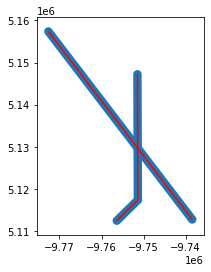

In [4]:
buf = lines.buffer(distance = 1000)
bp = buf.plot()
lines.plot(ax=bp, color='red')
print(buf)

Notice that we now have to polygon GEOMETRIES. This no longer has the line attributes associated with it. If we want to add back the attribute data we need to replace the original geometry column with new buffer geometry values.

In [5]:
line_buffer = lines.copy()
line_buffer['geometry'] = buf
print(line_buffer)

   ID                                           geometry
0   1  POLYGON ((-9737657.488 5113325.388, -9737601.7...
1   2  POLYGON ((-9750364.761 5117342.850, -9750369.3...


There are a number of other parameters available to use, namely `cap_style`, and `single_sided`.

<AxesSubplot:>

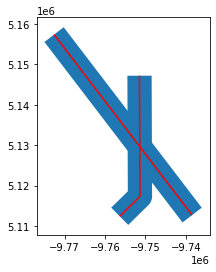

In [6]:
buf = lines.buffer(distance = 3000, cap_style = 2)
bp = buf.plot()
lines.plot(ax=bp, color='red')

```{table} Buffer caps can be different shapes
:name: cap_style

| attribute | value |
|---|---|
| round | 1 |
| flat  | 2 |
| square | 3 |
```

We can also create left or right side buffers. Use negative distances for left, and positive values for right.

<AxesSubplot:>

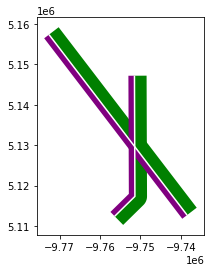

In [7]:
buf_right = lines.buffer(distance = 3000, single_sided = True)
bp = buf_right.plot(color='green')

buf_left = lines.buffer(distance = -1500, single_sided = True)
buf_left.plot(ax=bp, color='purple')
lines.plot(ax=bp, color='white')

 
## Nearest Neighbor Analysis

One commonly used GIS task is to be able to find the nearest neighbor. For instance, you might have a single Point object representing your home location, and then another set of locations representing e.g. public transport stops. Then, quite typical question is *"which of the stops is closest one to my home?"* This is a typical nearest neighbor analysis, where the aim is to find the closest geometry to another geometry. [^gpd_clip]

In Python this kind of analysis can be done with shapely function called `nearest_points()` that returns a tuple of the [nearest points](https://shapely.readthedocs.io/en/latest/manual.html#shapely.ops.nearest_points) in the input geometries.

### Nearest point using Shapely

Let's start by testing how we can find the nearest Point using the `nearest_points` function of Shapely.

Let's create an origin Point and a few destination Points and find out the closest destination.

In [8]:
from shapely.geometry import Point, MultiPoint
from shapely.ops import nearest_points

orig = Point(1, 1.67)
dest1, dest2, dest3 = Point(0, 1.45), Point(2, 2), Point(0, 2.5)


To be able to find out the closest destination point from the origin, we need to create a MultiPoint object from the destination points.

In [9]:
destinations = MultiPoint([dest1, dest2, dest3])
print(destinations)

MULTIPOINT (0 1.45, 2 2, 0 2.5)


Okey, now we can see that all the destination points are represented as a single MultiPoint object. Now we can find out the nearest destination point by using `nearest_points()` function.

In [10]:
nearest_geoms = nearest_points(orig, destinations)
original_point, nearest_destination = nearest_geoms
print(nearest_geoms)
print('Coordinates of original point:',original_point)
print('Coordinates of closest destination point:',nearest_destination)

(<shapely.geometry.point.Point object at 0x7f8f18f84050>, <shapely.geometry.point.Point object at 0x7f8f18e82b50>)
Coordinates of original point: POINT (1 1.67)
Coordinates of closest destination point: POINT (0 1.45)


As you can see the `nearest_points` function returns a tuple of geometries where the first item is the geometry of our origin point and the second item (at index 1) is the actual nearest geometry from the destination points. Hence, the closest destination point seems to be the one located at coordinates (0, 1.45).

This is the basic logic how we can find the nearest point from a set of points.

### Nearest points using Geopandas

Of course, the previous example is not really useful yet. Hence, next I show, how it is possible to find nearest points from a set of origin points to a set of destination points using GeoDataFrames. In this example we will recreate the previous example but use geopandas, however this data could come from any shapefile. 

- First we need to create a function that takes advantage of the previous function but is tailored to work with two GeoDataFrames.

In [11]:
def _nearest(row, df1, df2, geom1='geometry', geom2='geometry', df2_column=None):
    """Find the nearest point and return the corresponding value from specified column."""

    # create object usable by Shapely
    geom_union = df2.unary_union

    # Find the geometry that is closest
    nearest = df2[geom2] == nearest_points(row[geom1], geom_union)[1]
    # Get the corresponding value from df2 (matching is based on the geometry)
    if df2_column is None:
        value = df2[nearest].index[0]
    else:
        value = df2[nearest][df2_column].values[0]
    return value

def nearest(df1, df2, geom1_col='geometry', geom2_col='geometry', df2_column=None):
    """Find the nearest point and return the corresponding value from specified column.
    :param df1: Origin points
    :type df1: geopandas.GeoDataFrame
    :param df2: Destination points
    :type df2: geopandas.GeoDataFrame
    :param geom1_col: name of column holding coordinate geometry, defaults to 'geometry'
    :type geom1_col: str, optional
    :param geom2_col: name of column holding coordinate geometry, defaults to 'geometry'
    :type geom2_col: str, optional
    :param df2_column: column name to return from df2, defaults to None
    :type df2_column: str, optional
    :return: df1 with nearest neighbor index or df2_column appended
    :rtype: geopandas.GeoDataFrame
    """
    df1['nearest_id'] = df1.apply(_nearest,  df1=df1, df2=df2, 
                                  geom1=geom1_col, geom2=geom2_col, 
                                  df2_column=df2_column, axis=1)
    return df1 

In [12]:
# generate origin and destination points as geodataframe
orig = {'name': ['Origin_1','Origin_2'], 
     'geometry': [Point(-77.3,38.94),Point(-77.41,39.93)]}
orig = gpd.GeoDataFrame(orig, crs="EPSG:4326")
print(orig)

dest = {'name': ['Baltimore','Washington', 'Fredrick'], 
     'geometry': [ Point(-76.61,39.29,), Point(-77.04,38.91), Point(-77.40,39.41)]}
dest = gpd.GeoDataFrame(dest, crs="EPSG:4326")
print(dest)

       name                    geometry
0  Origin_1  POINT (-77.30000 38.94000)
1  Origin_2  POINT (-77.41000 39.93000)
         name                    geometry
0   Baltimore  POINT (-76.61000 39.29000)
1  Washington  POINT (-77.04000 38.91000)
2    Fredrick  POINT (-77.40000 39.41000)


Okay now we are ready to use our function and find closest Points (taking the value from id column) from df2 to df1 centroids

In [13]:
nearest = nearest(df1=orig, df2=dest, df2_column='name')
nearest.head()

,name,geometry,nearest_id
0,Origin_1,POINT (-77.30000 38.94000),Washington
1,Origin_2,POINT (-77.41000 39.93000),Fredrick


That's it! Now we found the closest point for each centroid and got the `index` value or column name from our addresses into the `df1` GeoDataFrame.


```{note} If you want to do nearest neighbor analysis with polygons, you can simply use the centroid. If you have a geopandas polygon called poly, run poly['centroid'] = poly.centroid to store the centroid values in the attribute table.  
```


Sources
[^gpd_clip]: [automating-gis-processes](https://automating-gis-processes.github.io/2017/lessons/L3/nearest-neighbour.html)